<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [2]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [3]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import ml_collections
import wandb

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

Using device: cuda


## Config

In [4]:
cfg = ml_collections.ConfigDict()

# Logger
cfg.wandb_project = "cvpr2021"
cfg.dataset = "mnist_28x28"
cfg.wandb_entity = "ipl_uv"

cfg.batch_size = 128
cfg.num_workers = 8
cfg.seed = 123

# Data
cfg.n_train = 5_000
cfg.n_valid = 1_000
cfg.n_test = 10_000
cfg.noise = 0.05

# Model
cfg.loss_fn = "bpd"
cfg.n_layers = 8
cfg.multiscale = False
cfg.n_reflections = 10
cfg.n_bins = 8
cfg.model = "rnvp"
cfg.actnorm = True

# Training
cfg.num_epochs = 100
cfg.lr_scheduler = "cosine_annealing"
cfg.weight_decay = 1e-4
cfg.gamma = 0.99
cfg.learning_rate = 1e-3
cfg.n_total_steps = cfg.num_epochs * 55_000
print(cfg.n_total_steps)

# Testing
cfg.importance_samples = 8
cfg.temperature = 1.0

5500000


In [5]:
seed_everything(cfg.seed)

Global seed set to 123


123

## Logging

In [6]:
wandb_logger = WandbLogger(project=cfg.wandb_project, entity=cfg.wandb_entity)
wandb_logger.experiment.config.update(cfg)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (use `wandb login --relogin` to force relogin)


## Data

In [7]:
from pl_bolts.datamodules import MNISTDataModule
from torch.utils.data import DataLoader, random_split
from torchvision.datasets.mnist import MNIST
from torchvision import transforms

In [8]:


# mnist_dm = MNISTDataModule(
#     data_dir="/datadrive/eman/datasets/mnist/",
#     num_workers=4,
#     normalize=False,
#     batch_size=64,
#     seed=123,
#     transforms=train_transforms
    
    
# )
# mnist_dm.prepare_data(download=False)
# mnist_dm.setup()

In [9]:
def discretize(sample):
    return (sample * 255).to(torch.int32)
train_transforms = transforms.Compose(
    [
        # torchvision.transforms.RandomCrop(32, padding=4),
        # torchvision.transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        discretize
    ]
)

dataset = MNIST("/datadrive/eman/datasets/mnist/", train=True, download=True, transform=train_transforms)
mnist_test = MNIST("/datadrive/eman/datasets/mnist/", train=False, download=True, transform=train_transforms)
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=256)
val_loader = DataLoader(mnist_val, batch_size=256)
test_loader = DataLoader(mnist_test, batch_size=256)

# mnist_dm = MNISTDataModule(
#     data_dir="/datadrive/eman/datasets/mnist/",
#     num_workers=4,
#     normalize=False,
#     batch_size=64,
#     seed=123,
    
    
# )
# mnist_dm.prepare_data(download=False)
# mnist_dm.setup()

# train_loader = mnist_dm.train_dataloader()
# val_loader = mnist_dm.val_dataloader()
# test_loader = mnist_dm.test_dataloader()

In [10]:

# train_loader = mnist_dm.train_dataloader()

In [11]:
X_init = []

for i, (ix, iy) in enumerate(train_loader):
    
    if isinstance(X_init, list):
        X_init = ix
    else:
        X_init = torch.cat([X_init, ix], dim=0)

    if X_init.shape[0] > 1_000:
        break

In [12]:
X_init.shape, X_init.min(), X_init.max()

(torch.Size([1024, 1, 28, 28]),
 tensor(0, dtype=torch.int32),
 tensor(255, dtype=torch.int32))

In [13]:
from torchvision.utils import make_grid

def visualize_images(input_imgs):

    grid = make_grid(input_imgs.to(torch.int32), nrow=8, ncols=8)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,7))
    plt.title(f"Images")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

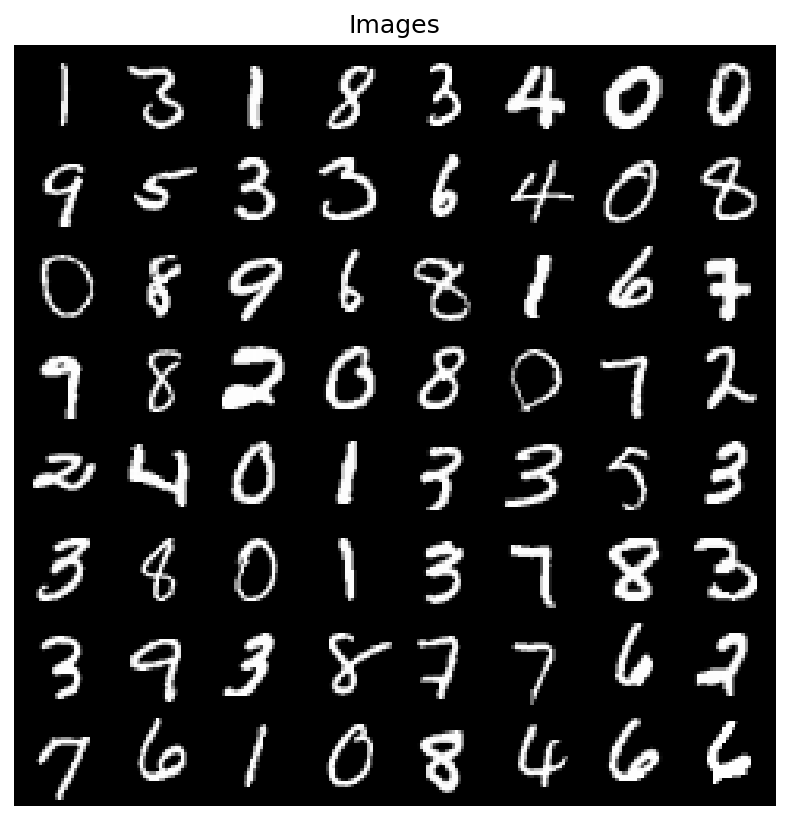

In [14]:
visualize_images(X_init[:64])

#### DataLoader

## Model

## Normalizing Flow Models

In [15]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.dequantization import UniformDequantization
from src.models.layers.convolutions import Conv1x1, Conv1x1Householder, ConvExponential
from src.models.layers.multiscale import SplitPrior

### RealNVP Model

In [16]:
from src.models.flows.realnvp import append_realnvp_coupling_block_image
from src.models.flows.gaussianization import append_gaussflow_image_block, append_gaussflow_tabular_block
from src.experiments.utils import gf_propagate

In [17]:
X_init.shape

torch.Size([1024, 1, 28, 28])

#### Architecture (Simple)

In [40]:
# a simple chain of operations is collected by ReversibleSequential
from tqdm.notebook import trange

n_channels = 1
height = 28
width = 28

inn = Ff.SequenceINN(n_channels, height, width)

init_X = X_init

print("Input:")
print(init_X.shape, np.prod(inn(init_X)[0].shape[1:]))


# uniform dequantization (for integers)
inn.append(UniformDequantization, num_bits=8)

init_X = gf_propagate(inn, X_init)



print(init_X.min(), init_X.max())


for isubflow in trange(4):

    # append RealNVP Coupling Block
    inn, _ = append_gaussflow_image_block(inn, init_X=init_X, non_linear="rqsplines", n_components=12, n_reflections=20, )
    
    
print("Flatten:")
inn.append(Fm.Flatten)
print(init_X.shape, np.prod(inn(X_init)[0].shape[1:]))

print("Final:")
print(init_X.shape, np.prod(inn(X_init)[0].shape[1:]))

Input:
torch.Size([1024, 1, 28, 28]) 784
tensor(0.) tensor(1.0000)


  0%|          | 0/4 [00:00<?, ?it/s]

Flatten:
torch.Size([1024, 1, 28, 28]) 784
Final:
torch.Size([1024, 1, 28, 28]) 784


### Architecture (Multiscale)

In [43]:
# a simple chain of operations is collected by ReversibleSequential
from tqdm.notebook import trange

n_channels = 1
height = 28
width = 28

inn = Ff.SequenceINN(n_channels, height, width)

init_X = X_init[:64]

print("Input:")
print(init_X.shape, np.prod(inn(init_X)[0].shape[1:]))


# uniform dequantization (for integers)
inn.append(UniformDequantization, num_bits=8)

init_X = gf_propagate(inn, X_init)



print(init_X.min(), init_X.max())


for isubflow in trange(4):

    # append RealNVP Coupling Block
    inn, init_X = append_gaussflow_image_block(inn, init_X=init_X, non_linear="rqsplines", n_components=12, n_reflections=2, )
    
# SCALE I
print(f"Scale: 1")
print("DownSample")
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape, np.prod(inn(X_init)[0].shape[1:]))
init_X = gf_propagate(inn, init_X)


for isubflow in trange(4):

    # append RealNVP Coupling Block
    inn, init_X = append_gaussflow_image_block(inn, init_X=init_X, non_linear="rqsplines", n_components=12, n_reflections=8, )

    
# SCALE I
print(f"Scale: 2")
print("DownSample")
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape, np.prod(inn(X_init)[0].shape[1:]))
init_X = gf_propagate(inn, init_X)


for isubflow in trange(4):

    # append RealNVP Coupling Block
    inn, init_X = append_gaussflow_image_block(inn, init_X=init_X, non_linear="rqsplines", n_components=12, n_reflections=8, )


    
print("Flatten:")
inn.append(Fm.Flatten)
print(init_X.shape, np.prod(inn(X_init)[0].shape[1:]))

print("Final:")
print(init_X.shape, np.prod(inn(X_init)[0].shape[1:]))

Input:
torch.Size([64, 1, 28, 28]) 784
tensor(4.4238e-09) tensor(1.0000)


  0%|          | 0/4 [00:00<?, ?it/s]

Scale: 1
DownSample
torch.Size([1024, 4, 14, 14]) 784


  0%|          | 0/4 [00:00<?, ?it/s]

Scale: 2
DownSample
torch.Size([1024, 16, 7, 7]) 784


  0%|          | 0/4 [00:00<?, ?it/s]

Flatten:
torch.Size([1024, 16, 7, 7]) 784
Final:
torch.Size([1024, 16, 7, 7]) 784


In [85]:
# # a simple chain of operations is collected by ReversibleSequential

# batch = 100
# n_channels = 1
# height = 28
# width = 28


# inn = Ff.SequenceINN(n_channels, height, width)


# # uniform dequantization (for integers)
# inn.append(
#     UniformDequantization,
#     num_bits=8
# )

# print("Input:")
# print(X_init.shape, np.prod(inn(X_init)[0].shape))


# # subset net
# def subnet_conv(c_in, c_out):
#     return nn.Sequential(nn.Conv2d(c_in, 32,   3, padding=1), nn.ReLU(),
#                         nn.Conv2d(32,  c_out, 3, padding=1))


# for isubflow in range(2):
    
#     # append RealNVP Coupling Block
#     inn = append_realnvp_coupling_block_image(
#         inn,
#         conditioner=subnet_conv, 
#         actnorm=True, 
#         n_reflections=20,
#         mask="wavelet"
#     )

# # SCALE I
# print(f"Scale: 1")
# print("DownSample")
# inn.append(
#     Fm.IRevNetDownsampling, 
# )

# print(inn(X_init)[0].shape, np.prod(inn(X_init)[0].shape))

# # subset net
# def subnet_conv(c_in, c_out):
#     return nn.Sequential(nn.Conv2d(c_in, 48,   3, padding=1), nn.ReLU(),
#                         nn.Conv2d(48,  c_out, 3, padding=1))
    
# for isubflow in range(2):
        
#     # append RealNVP Coupling Block
#     inn = append_realnvp_coupling_block_image(
#         inn,
#         conditioner=subnet_conv, 
#         actnorm=True, 
#         n_reflections=20,
#         mask="wavelet"
#     )
    
# print("Split I")
# inn.append(
#     SplitPrior, 
#     prior = dist.Normal(0.0, 1.0)
# )
# print(inn(X_init)[0].shape, np.prod(inn(X_init)[0].shape))

# # SCALE I
# print(f"Scale II")
# print("DownSample")
# inn.append(
#     Fm.IRevNetDownsampling, 
# )

# print(inn(X_init)[0].shape, np.prod(inn(X_init)[0].shape))


# # subset net
# def subnet_conv(c_in, c_out):
#     return nn.Sequential(nn.Conv2d(c_in, 64,   3, padding=1), nn.ReLU(),
#                         nn.Conv2d(64,  c_out, 3, padding=1))
    
# for isubflow in range(4):
        
#     # append RealNVP Coupling Block
#     inn = append_realnvp_coupling_block_image(
#         inn,
#         conditioner=subnet_conv, 
#         actnorm=True, 
#         n_reflections=20,
#         mask=None
#     )

    
    
    
# inn.append(Fm.Flatten)
# print("Final:")
# print(inn(X_init)[0].shape)

## Image Flow Model

In [44]:
from src.lit_image import ImageFlow

In [45]:
# Training
cfg.num_epochs = 100
cfg.lr_scheduler = "cosine_annealing"
cfg.weight_decay = 1e-4
cfg.gamma = 0.99
cfg.learning_rate = 5e-4
cfg.n_total_steps = cfg.num_epochs * 55_000
cfg.n_total_dims = 784

In [46]:
flow_img_mnist = ImageFlow(inn, cfg=cfg, prior=None)

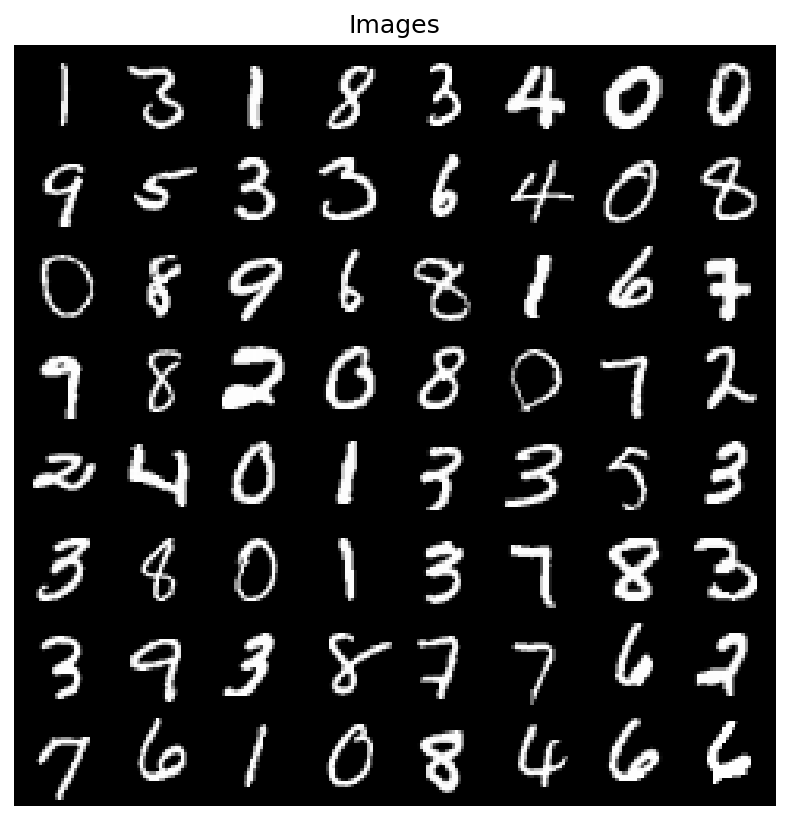

In [47]:
visualize_images(X_init[:64])

### Forward

In [48]:
print(X_init.shape, X_init.min(), X_init.max())

with torch.no_grad():
    z, log_jac_det = flow_img_mnist.model.forward(X_init)
print(z.shape, z.min(), z.max())

torch.Size([1024, 1, 28, 28]) tensor(0, dtype=torch.int32) tensor(255, dtype=torch.int32)
torch.Size([1024, 784]) tensor(-13.2959) tensor(14.1095)


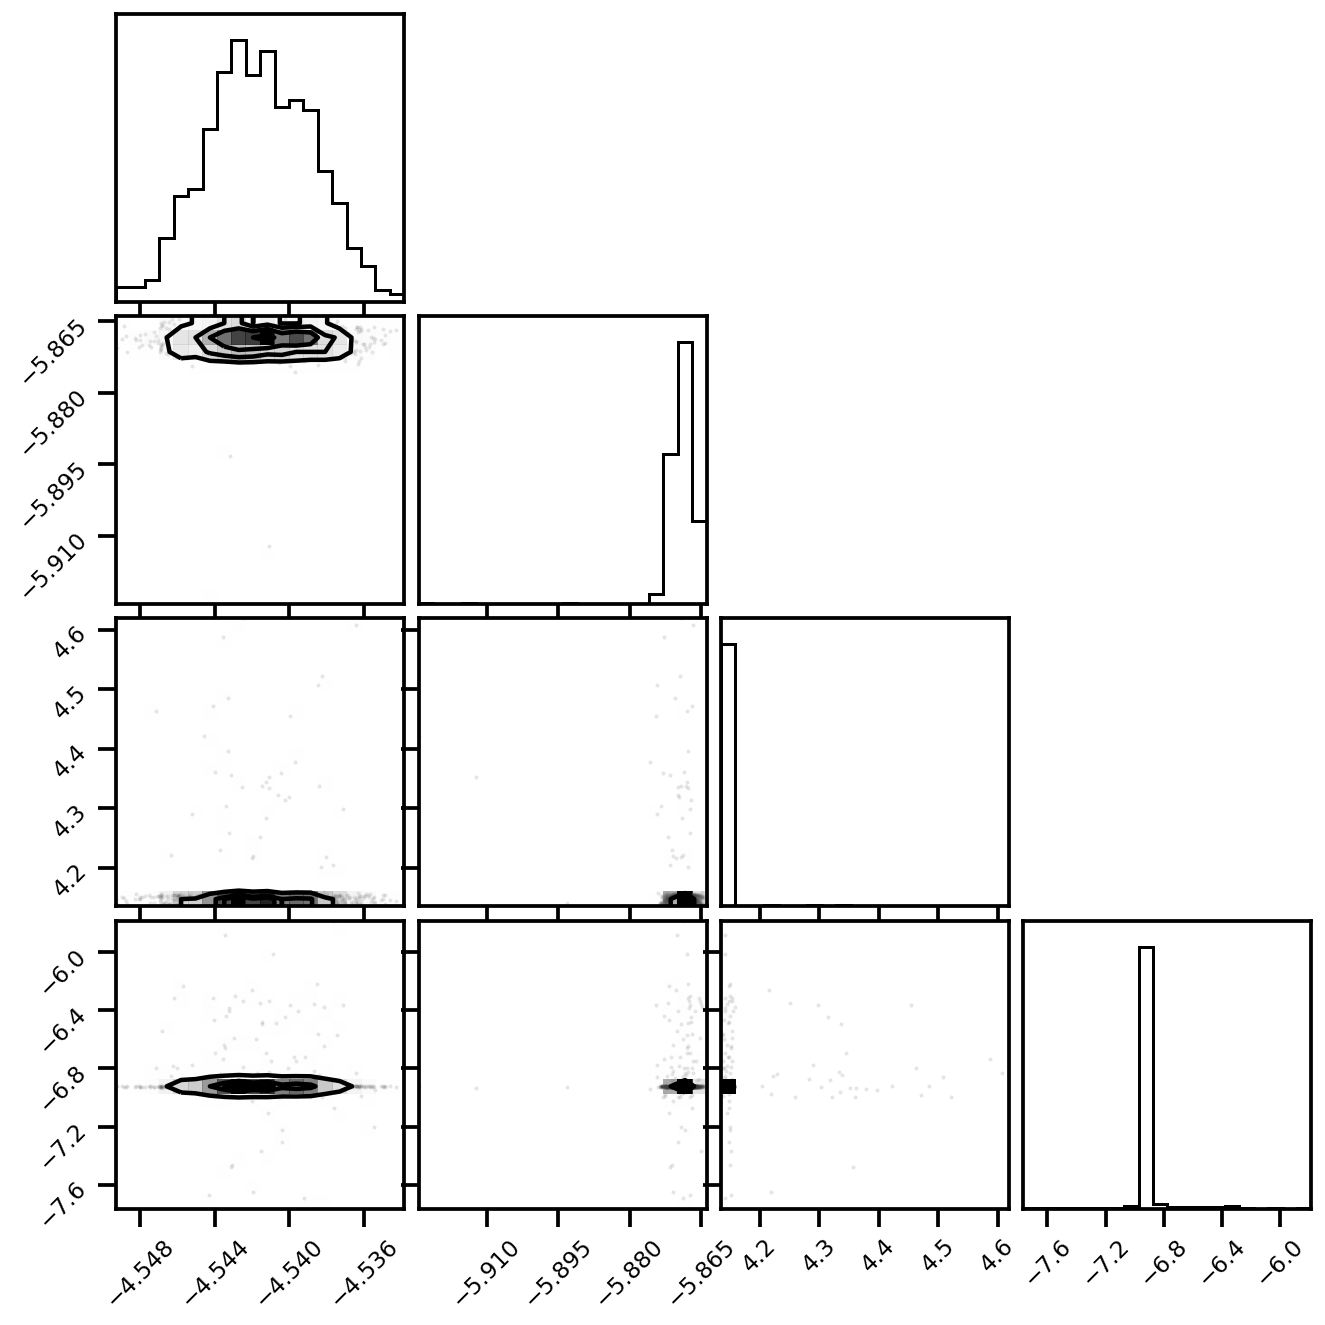

In [49]:
fig = corner.corner(z.cpu().numpy()[:, :4])

#### Inverse

In [50]:
with torch.no_grad():

    x_ori, log_jac_det = flow_img_mnist.model.forward(z, rev=True)
print(x_ori.shape, x_ori.min(), x_ori.max())

torch.Size([1024, 1, 28, 28]) tensor(0) tensor(255)


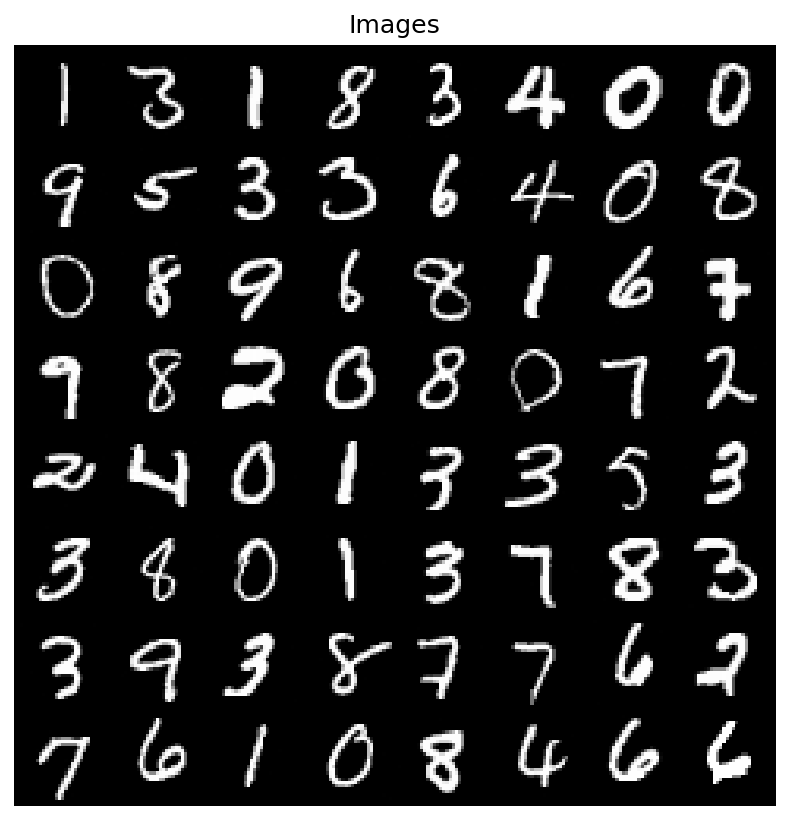

In [51]:
visualize_images(x_ori[:64])

#### Samples

In [52]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 64
# z = torch.randn(n_samples, N_DIM)
with torch.no_grad():
    samples = flow_img_mnist.sample((n_samples, 784))

# plot_digits(samples.detach().numpy().squeeze(), 4, 4)

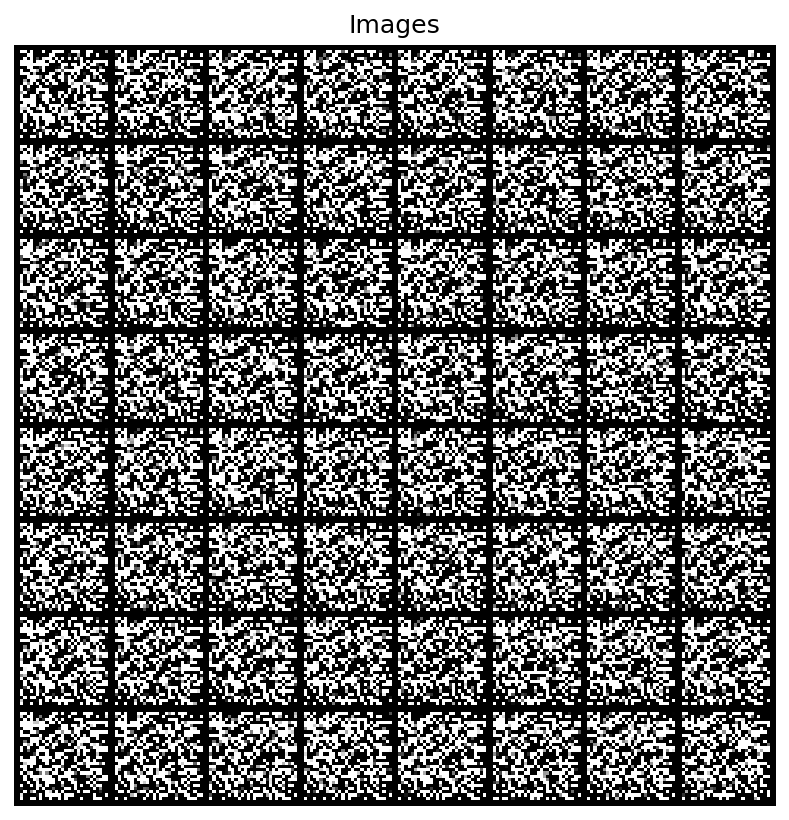

In [53]:
visualize_images(samples)

## Training

In [87]:
from src.callbacks.images import LogEvalImages

In [88]:


trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=10, 
    # device
    gpus=1,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm',
    logger=wandb_logger,
    callbacks=[
        LogEvalImages(input_imgs=X_init)
    ]
    
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
%%wandb

trainer.fit(flow_img_mnist, train_dataloader=train_loader, val_dataloaders=val_loader)
# trainer.fit(flow_img_mnist, datamodule=mnist_dm)

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 580 K 
--------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K     Total params
2.321     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 123
/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


#### Latent Space

In [117]:
x = torch.Tensor(X_init)
z, log_jac_det = flow_img_mnist.model(X_init)

# plot_digits(z.detach().numpy(), 4, 4)

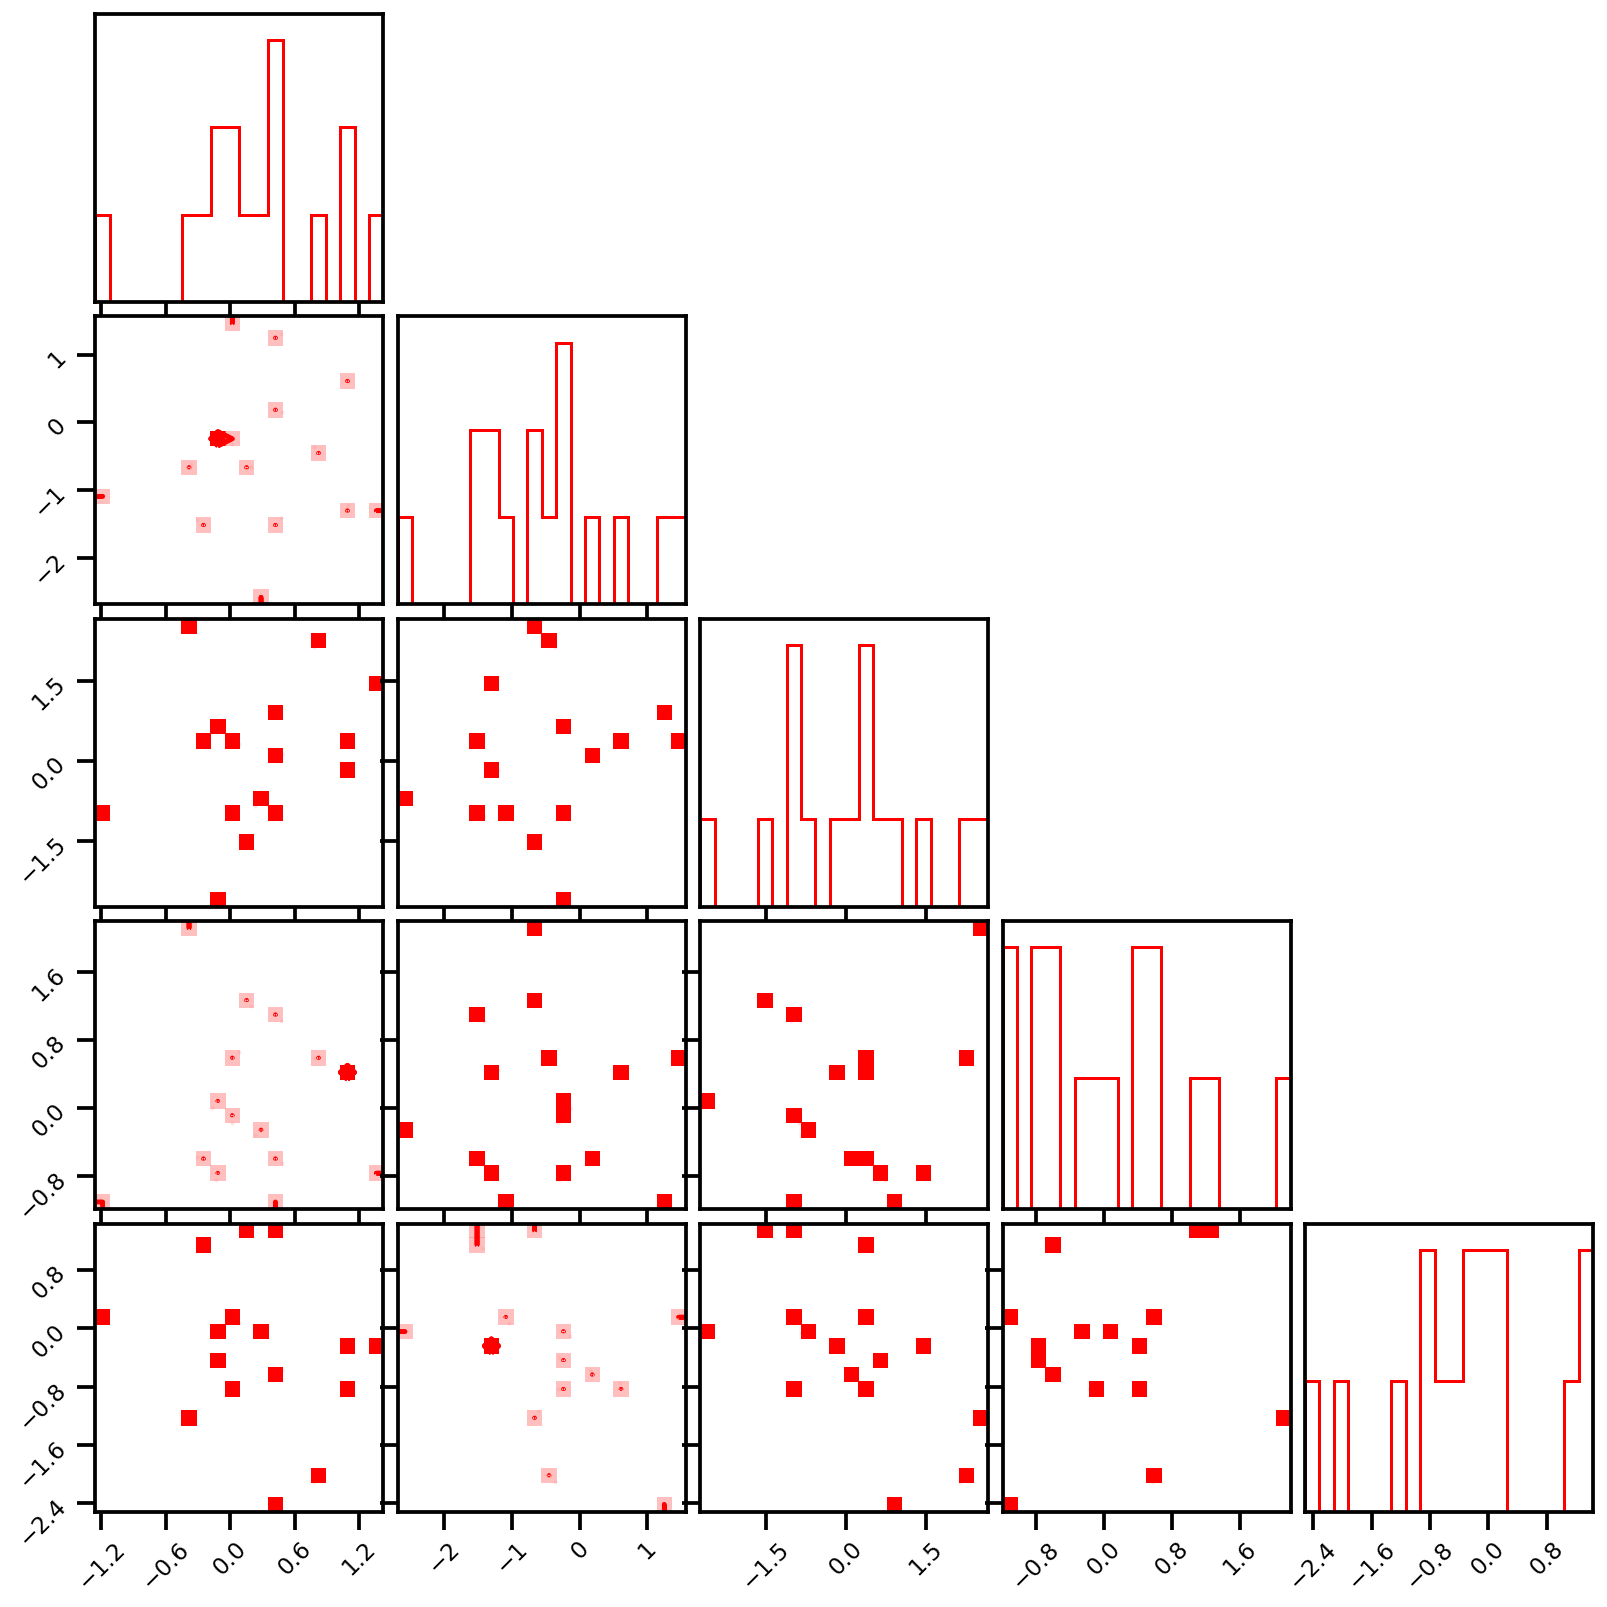

In [118]:
fig = corner.corner(z.detach().numpy()[:, :5], hist_factor=2, color="red")

#### Inverse Transform

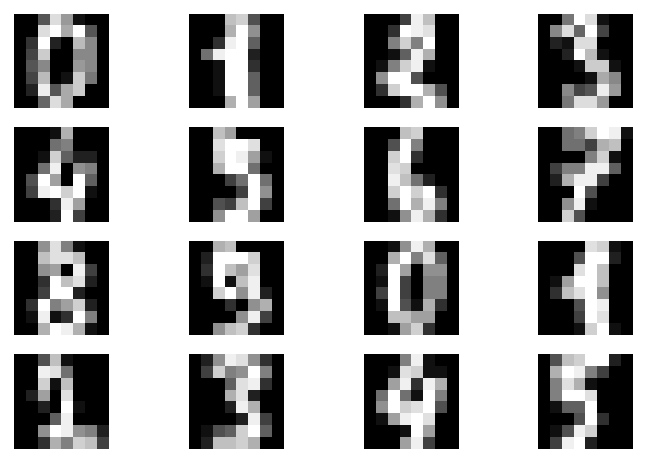

In [119]:
x_ori, _ = flow_img_mnist.model.forward(z, rev=True)

plot_digits(x_ori.detach().numpy().squeeze(), 4, 4)

In [120]:
x_ori.shape

torch.Size([16, 1, 8, 8])

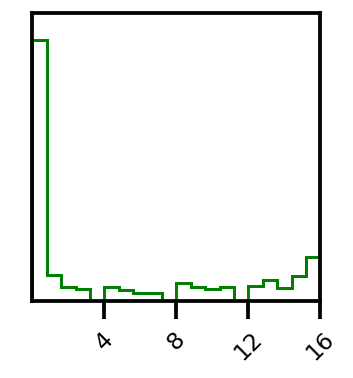

In [105]:
fig = corner.corner(x_ori.detach().numpy()[:, :5, ...].flatten(), hist_factor=2, color="green")

#### Sampling

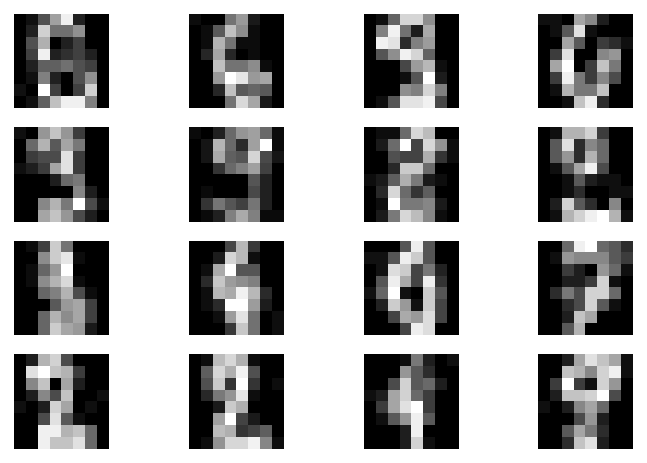

In [121]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 16
# z = torch.randn(n_samples, N_DIM)
samples = flow_img_mnist.sample((100, 64))

plot_digits(samples.detach().numpy().squeeze(), 4, 4)

In [ ]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")